# Room Schedule Analysis
----
The purpose of this notebook is to process downloaded Google Sheets that hold room schedule info for counseling sessions. These sheets are used to book rooms for counseling sessions. Each sheet holds data for a two-week period, where each week is in a separate tab. 

#### 1. Notebook setup
----

(optional) Anonymize data for GitHub hosting
> This will anonymize and add noise to data

In [1]:
anonymize = True
seed = 2

Import libraries

In [2]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
from faker import Faker
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Patch
import matplotlib.patches as mpatches
from datetime import datetime, timedelta, time

Load and process sheets

In [3]:
# filepath to workbooks data
folder_path = r"C:\Users\aarev\Documents\ThinkPad_E14\APU\Analysis\Room Schedule Project\sheets"
# file path to processed workbook data
csv_path = r"C:\Users\aarev\Documents\ThinkPad_E14\APU\Analysis\Room Schedule Project\full_schedule.csv"


# check if processed workbooks csv exists
if os.path.exists(csv_path):
    print(f"CSV already exists at {csv_path}, skipping processing.")
    df = pd.read_csv(csv_path)
else:
    # function to process a day in schedule
    def process_day(df, day_name, col_start, col_end):
        time_col = df.columns[0]
        day_cols = df.columns[col_start:col_end]
        day_df = df[[time_col] + list(day_cols)].copy()
        day_df = day_df.rename(columns={time_col: "Time"})
        melted = day_df.melt(id_vars="Time", var_name="Room", value_name="Person").dropna(subset=["Person"])
        melted["Day"] = day_name
        return melted

    # function that cleans room names
    def clean_room(room):
        try:
            return str(int(float(room)))
        except Exception:
            return str(room).strip()

    # sheet mapping for day to cell range 
    day_ranges = {
        "Monday": (1, 9),
        "Tuesday": (10, 18),
        "Wednesday": (19, 27),
        "Thursday": (28, 36),
        "Friday": (37, 45),
    }

    # holds processed shedules
    all_data = []

    # process each sheet and tabs within sheet
    for filename in os.listdir(folder_path):
        if filename.endswith(".xlsx") or filename.endswith(".xls"):
            file_path = os.path.join(folder_path, filename)
            print(f"Processing workbook: {filename}")

            xls = pd.ExcelFile(file_path)
            for sheet_name in xls.sheet_names:
                if sheet_name.lower().startswith("week of"):
                    print(f"  Processing sheet: {sheet_name}")
                    df = pd.read_excel(file_path, sheet_name=sheet_name, header=3).iloc[0:12]

                    # process each day in week
                    week_schedule = pd.concat(
                        [process_day(df, day, start, end) for day, (start, end) in day_ranges.items()],
                        ignore_index=True,
                    )

                    # add session/schedule info
                    week_schedule["Room"] = week_schedule["Room"].apply(clean_room)
                    week_schedule["Week"] = sheet_name
                    week_schedule["Workbook"] = filename

                    # consolidate sheet results
                    all_data.append(week_schedule)

    # combine all data
    df = pd.concat(all_data, ignore_index=True)

    # save the combined DataFrame to CSV
    output_path = os.path.join(folder_path, "full_schedule.csv")
    df.to_csv(output_path, index=False)
    print(f"Saved combined schedule to: {output_path}")

# df.head()

CSV already exists at C:\Users\aarev\Documents\ThinkPad_E14\APU\Analysis\Room Schedule Project\full_schedule.csv, skipping processing.


#### 2. Preprocess Data
----

Anonymize data for privacy purposes

In [4]:
if anonymize == True:
    
    # initialize Faker
    fake = Faker()
    Faker.seed(seed)  # seed for reproducibility

    ### Step 1: Mask Room numbers (e.g., 101 → R100)
    room_map = {room: f'R{100 + i}' for i, room in enumerate(df['Room'].unique())}
    df['Room'] = df['Room'].map(room_map)

    ### Step 2: Anonymize names in 'Person' using Faker
    # 1. Extract all unique names
    all_names = set()
    for entry in df['Person']:
        all_names.update([n.strip() for n in entry.split('/')])

    # 2. Map to fake names
    fake_name_map = {name: fake.first_name() for name in all_names}

    # 3. Replace names in Person column
    def anonymize_person(entry):
        return '/'.join(fake_name_map[n.strip()] for n in entry.split('/'))

    df['Person'] = df['Person'].apply(anonymize_person)

df.head()

,Time,Room,Person,Day,Week,Workbook
0,14:00:00,R100,Patrick/Kenneth,Monday,Week of 1021-1025,APU CCC Schedule 10_21 - 11_1.xlsx
1,16:00:00,R100,Patrick/Barry,Monday,Week of 1021-1025,APU CCC Schedule 10_21 - 11_1.xlsx
2,17:00:00,R100,Emily/Kyle,Monday,Week of 1021-1025,APU CCC Schedule 10_21 - 11_1.xlsx
3,18:00:00,R100,Emily/Kyle,Monday,Week of 1021-1025,APU CCC Schedule 10_21 - 11_1.xlsx
4,16:00:00,R101,James,Monday,Week of 1021-1025,APU CCC Schedule 10_21 - 11_1.xlsx


Extract hour

In [5]:
# clean and convert the 'Time' column
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S', errors='coerce')

# extract the hour directly
df['Hour'] = df['Time'].dt.hour

Sort sessions into Time of Day using hour

In [6]:
def time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour <= 22:
        return 'Evening'
    else:
        return 'Late Night'  # just in case

df['Time of Day'] = df['Hour'].apply(time_of_day)


Extract session date

In [7]:
# map day names to offsets from Monday
day_offset = {
    'Monday': 0,
    'Tuesday': 1,
    'Wednesday': 2,
    'Thursday': 3,
    'Friday': 4,
    'Saturday': 5,
    'Sunday': 6
}

# function to parse start date from week string
def parse_week_start(week_str):
    match = pd.to_datetime(week_str.split(" ")[-1].split("-")[0], format="%m%d", errors='coerce')
    if pd.notnull(match):
        return match.replace(year=2024)  # or 2025, depending on your data
    return pd.NaT

# apply start date parsing
df['Week Start'] = df['Week'].apply(parse_week_start)

# calculate actual session date
df['Session Date'] = df.apply(lambda row: row['Week Start'] + timedelta(days=day_offset.get(row['Day'], 0)), axis=1)

# extract Month
df['Month'] = df['Session Date'].dt.month_name()


See results DF

In [8]:
df.head()

,Time,Room,Person,Day,Week,Workbook,Hour,Time of Day,Week Start,Session Date,Month
0,1900-01-01 14:00:00,R100,Patrick/Kenneth,Monday,Week of 1021-1025,APU CCC Schedule 10_21 - 11_1.xlsx,14.0,Afternoon,2024-10-21,2024-10-21,October
1,1900-01-01 16:00:00,R100,Patrick/Barry,Monday,Week of 1021-1025,APU CCC Schedule 10_21 - 11_1.xlsx,16.0,Afternoon,2024-10-21,2024-10-21,October
2,1900-01-01 17:00:00,R100,Emily/Kyle,Monday,Week of 1021-1025,APU CCC Schedule 10_21 - 11_1.xlsx,17.0,Evening,2024-10-21,2024-10-21,October
3,1900-01-01 18:00:00,R100,Emily/Kyle,Monday,Week of 1021-1025,APU CCC Schedule 10_21 - 11_1.xlsx,18.0,Evening,2024-10-21,2024-10-21,October
4,1900-01-01 16:00:00,R101,James,Monday,Week of 1021-1025,APU CCC Schedule 10_21 - 11_1.xlsx,16.0,Afternoon,2024-10-21,2024-10-21,October


Print quick tables of session volume by month, weekday, and time of day

In [9]:
def add_percentage_column(df, count_col='Sessions'):
    total = df[count_col].sum()
    df['Percent'] = (df[count_col] / total * 100).round(2).astype(str) + '%'
    return df

# sessions by Month
monthly_counts = (
    df.groupby('Month')
    .size()
    .reset_index(name='Sessions')
    .sort_values('Month')
)
monthly_counts = add_percentage_column(monthly_counts)
print("Sessions by Month:")
print(monthly_counts)

# sessions by Day of Week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
df['Day'] = pd.Categorical(df['Day'], categories=day_order, ordered=True)

day_counts = (
    df.groupby('Day')
    .size()
    .reset_index(name='Sessions')
    .sort_values('Day')
)
day_counts = add_percentage_column(day_counts)
print("\nSessions by Day of Week:")
print(day_counts)

# sessions by Time of Day
time_order = ['Morning', 'Afternoon', 'Evening']
df['Time of Day'] = pd.Categorical(df['Time of Day'], categories=time_order, ordered=True)

time_counts = (
    df.groupby('Time of Day')
    .size()
    .reset_index(name='Sessions')
    .sort_values('Time of Day')
)
time_counts = add_percentage_column(time_counts)
print("\nSessions by Time of Day:")
print(time_counts)

Sessions by Month:
        Month  Sessions Percent
0       April       464  11.84%
1      August       216   5.51%
2    December       350   8.93%
3    February       461  11.77%
4     January       118   3.01%
5        July       147   3.75%
6        June       135   3.45%
7       March       398  10.16%
8         May       490  12.51%
9    November       484  12.35%
10    October       331   8.45%
11  September       324   8.27%

Sessions by Day of Week:
         Day  Sessions Percent
0     Monday      1011   25.8%
1    Tuesday       997  25.45%
2  Wednesday       973  24.83%
3   Thursday       556  14.19%
4     Friday       381   9.72%

Sessions by Time of Day:
  Time of Day  Sessions Percent
0     Morning      1020  26.24%
1   Afternoon      2022  52.02%
2     Evening       845  21.74%


C:\Users\aarev\AppData\Local\Temp\ipykernel_6932\2150317858.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('Day')
C:\Users\aarev\AppData\Local\Temp\ipykernel_6932\2150317858.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('Time of Day')


#### 3. Plotting
----

Plot session volume by **month**, by **weekday**, and by **time fo day**

C:\Users\aarev\AppData\Local\Temp\ipykernel_6932\3070165403.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_plot_data, x='Month', y='Sessions',


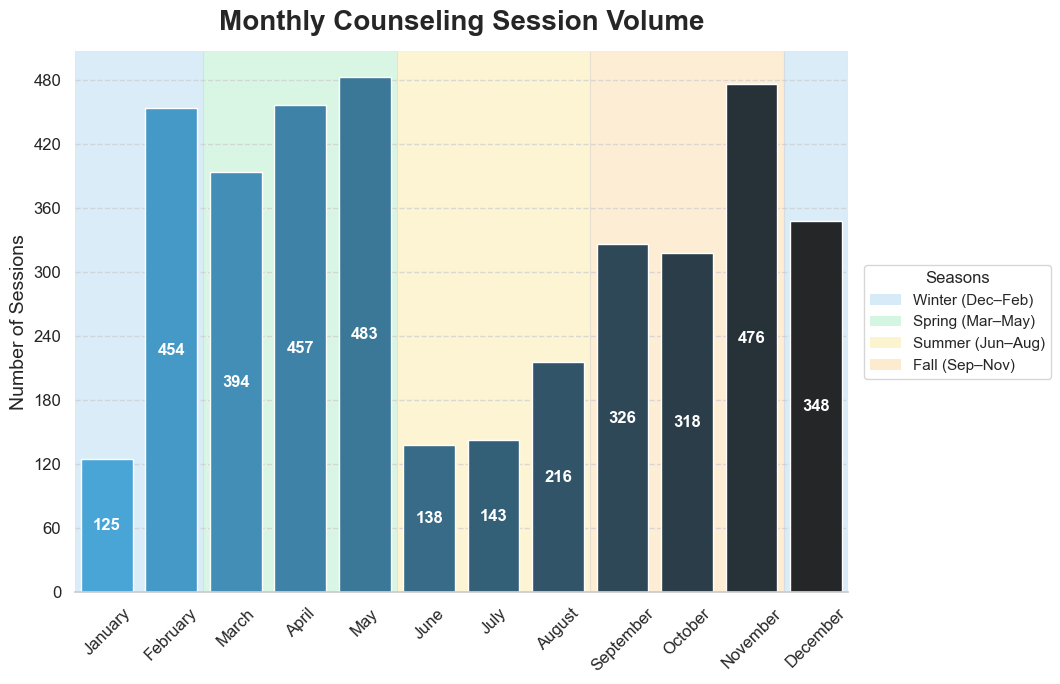

C:\Users\aarev\AppData\Local\Temp\ipykernel_6932\3070165403.py:112: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=weekday_plot_data, x='Day', y='Sessions', palette=green_palette, order=day_order)


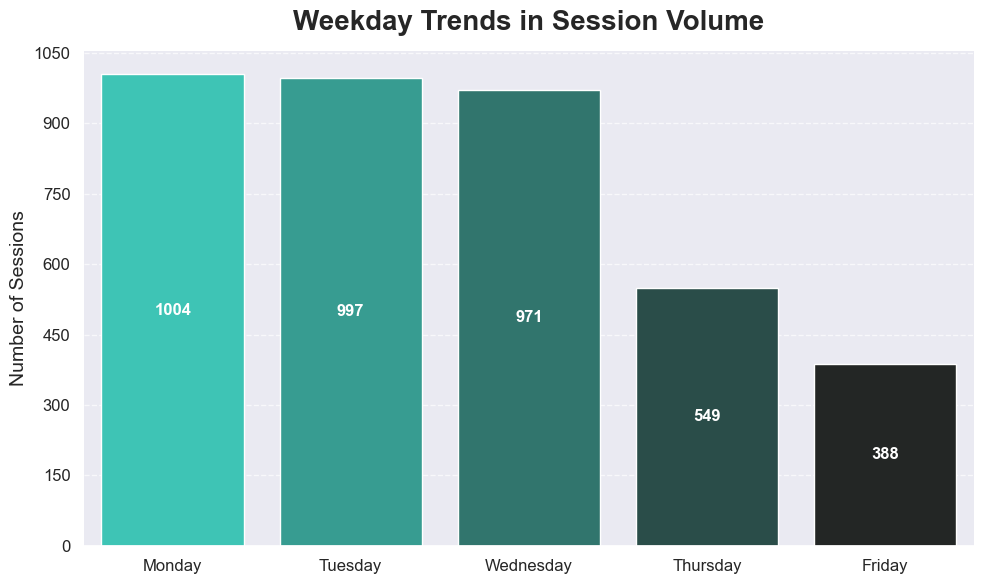

C:\Users\aarev\AppData\Local\Temp\ipykernel_6932\3070165403.py:132: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


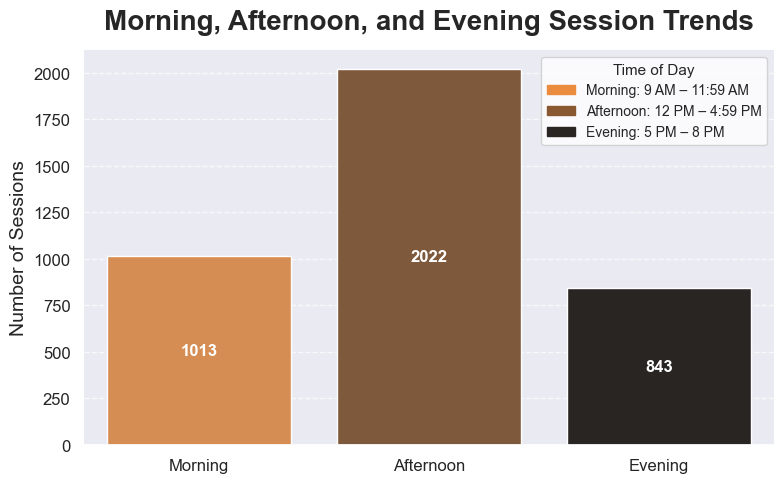

In [10]:

def add_noise(df, column='Sessions', max_noise=15, seed=None):
    if seed is not None:
        np.random.seed(seed)  # for reproducibility
    noise = np.random.randint(-max_noise, max_noise + 1, size=len(df))
    df_noised = df.copy()
    df_noised[column] = df_noised[column] + noise
    df_noised[column] = df_noised[column].clip(lower=0)  # avoid negative sessions
    return df_noised



def add_bar_labels(ax, min_height=50, anonymize=False, noise_range=15, seed=None):
    if anonymize and seed is not None:
        np.random.seed(seed)  # for reproducibility

    for p in ax.patches:
        height = p.get_height()
        if height >= min_height:
            label = int(round(height))  # use exact value
            ax.text(
                p.get_x() + p.get_width() / 2,
                height / 2,
                f'{label}',
                ha='center',
                va='center',
                color='white',
                fontsize=12,
                fontweight='bold'
            )


# ordering for plots
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
time_order = ['Morning', 'Afternoon', 'Evening']

# generate softer palettes by reversing the light_palette shades
blue_palette = sns.dark_palette("#31aced", n_colors=len(month_order), reverse=True)
green_palette = sns.dark_palette("#28dac6", n_colors=len(day_order), reverse=True)
orange_palette = sns.dark_palette("#eb8b3d", n_colors=len(time_order), reverse=True)


#------- Monthly session plot ----------

sns.set(style='whitegrid')

# setup figure and axis
fig, ax = plt.subplots(figsize=(12, 7))

# define season colors (darker alpha)
season_colors = {
    'Winter': '#D6EAF8',
    'Spring': '#D5F5E3',
    'Summer': '#FCF3CF',
    'Fall':   '#FDEBD0'
}

# shade background (first)
ax.axvspan(-0.5, 1.5, color=season_colors['Winter'], alpha=0.9, zorder=0.25)
ax.axvspan(1.5, 4.5, color=season_colors['Spring'], alpha=0.9, zorder=0.25)
ax.axvspan(4.5, 7.5, color=season_colors['Summer'], alpha=0.9, zorder=0.25)
ax.axvspan(7.5, 10.5, color=season_colors['Fall'], alpha=0.9, zorder=0.25)
ax.axvspan(10.5, 11.5, color=season_colors['Winter'], alpha=0.9, zorder=0.25)


# add vertical separators (light gray)
for x in [1.5, 4.5, 7.5, 10.5]:
    ax.axvline(x=x, color='lightgray', linestyle='-', linewidth=0.375, zorder=0.5)
    
# plot bar chart on top
monthly_plot_data = add_noise(monthly_counts, seed=seed) if anonymize else monthly_counts
sns.barplot(data=monthly_plot_data, x='Month', y='Sessions',
            palette=blue_palette, order=month_order, ax=ax)

# customize axes and titles
ax.set_title('Monthly Counseling Session Volume', fontsize=20, weight='bold', pad=15)
ax.set_xlabel('', fontsize=14)
ax.set_ylabel('Number of Sessions', fontsize=14)
ax.tick_params(axis='x', rotation=45, labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
sns.despine(left=True, bottom=False)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# add bar labels
add_bar_labels(ax, anonymize=anonymize, noise_range=15, seed=seed)

# create custom legend
legend_patches = [
    Patch(facecolor=season_colors['Winter'], edgecolor='none', label='Winter (Dec–Feb)'),
    Patch(facecolor=season_colors['Spring'], edgecolor='none', label='Spring (Mar–May)'),
    Patch(facecolor=season_colors['Summer'], edgecolor='none', label='Summer (Jun–Aug)'),
    Patch(facecolor=season_colors['Fall'], edgecolor='none', label='Fall (Sep–Nov)')
]

# add legend outside the plot (to the right, vertically centered)
ax.legend(handles=legend_patches, title='Seasons',
          bbox_to_anchor=(1.02, 0.5), loc='center left', borderaxespad=0.)

# final layout adjustments
plt.tight_layout(rect=[0, 0, 0.9, 1])  # leave space for the legend
plt.savefig('images/month_volume.png', dpi=600, bbox_inches="tight")
plt.show()

#------- Plot session volumn by weekday ------------
sns.set(style='darkgrid')

# plot Sessions by Day of Week
plt.figure(figsize=(10, 6))
weekday_plot_data = add_noise(day_counts, seed=seed) if anonymize else day_counts
ax = sns.barplot(data=weekday_plot_data, x='Day', y='Sessions', palette=green_palette, order=day_order)
ax.set_title('Weekday Trends in Session Volume', fontsize=20, weight='bold', pad=15)
ax.set_xlabel('', fontsize=14)
ax.set_ylabel('Number of Sessions', fontsize=14)
ax.tick_params(axis='x', rotation=0, labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
sns.despine(left=True, bottom=False)
plt.grid(axis='y', linestyle='--', alpha=0.7)
add_bar_labels(ax, anonymize=anonymize, noise_range=15, seed=seed)
plt.tight_layout()
plt.savefig('images/weekday_volume.png', dpi=600)
plt.show()


#--------- Plot session of day by time of day-----------

# plot Sessions by Time of Day
plt.figure(figsize=(8, 5))
time_plot_data = add_noise(time_counts, seed=seed) if anonymize else time_counts
ax = sns.barplot(
    data=time_plot_data,
    x='Time of Day',
    y='Sessions',
    palette=orange_palette,
    order=time_order
)

# titles and labels
ax.set_title('Morning, Afternoon, and Evening Session Trends', fontsize=20, weight='bold', pad=15)
ax.set_xlabel('', fontsize=14)
ax.set_ylabel('Number of Sessions', fontsize=14)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
sns.despine(left=True, bottom=False)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# add bar labels
add_bar_labels(ax, anonymize=anonymize, noise_range=15, seed=seed)

# create custom legend
legend_patches = [
    mpatches.Patch(color=orange_palette[0], label='Morning: 9 AM – 11:59 AM'),
    mpatches.Patch(color=orange_palette[1], label='Afternoon: 12 PM – 4:59 PM'),
    mpatches.Patch(color=orange_palette[2], label='Evening: 5 PM – 8 PM')
]
legend = ax.legend(handles=legend_patches, title='Time of Day', loc='upper right', fontsize=10, title_fontsize=11)
legend.get_frame().set_facecolor('white')  
# layout and save
plt.tight_layout()
plt.savefig('images/time_of_day_volume.png', dpi=600)
plt.show()


Plot session volumn by hour of day grouped by weekday

C:\Users\aarev\AppData\Local\Temp\ipykernel_6932\163305808.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  hour_day_counts = df.groupby(['Hour', 'Day']).size().unstack(fill_value=0)


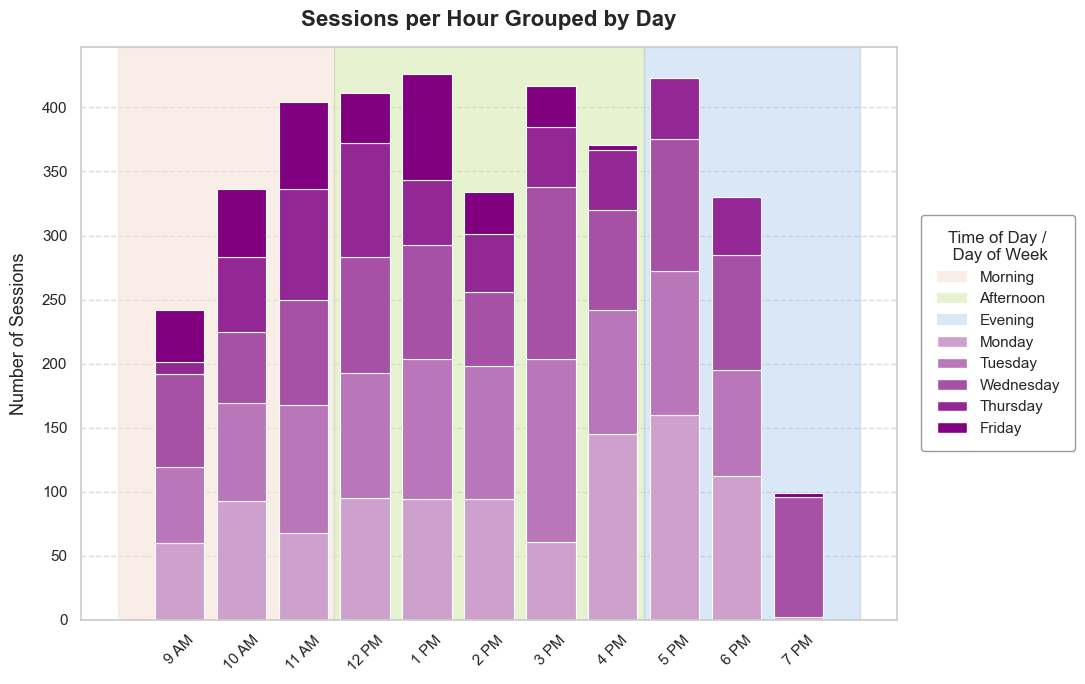

In [11]:
def add_noise_to_df(df, max_noise=15, seed=None):
    if seed is not None:
        np.random.seed(seed)
    noise = np.random.randint(-max_noise, max_noise + 1, size=df.shape)
    df_noised = df + noise
    df_noised = df_noised.clip(lower=0)  # avoid negatives
    return df_noised

# group by Hour and Day
hour_day_counts = df.groupby(['Hour', 'Day']).size().unstack(fill_value=0)

# ensure correct order of days
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
hour_day_counts = hour_day_counts[day_order]
hour_day_counts = hour_day_counts.sort_index()

# set purple shades for the bars
colors = sns.light_palette("purple", n_colors=len(day_order) + 2, input="name")[2:]

# set style and figure size
sns.set_style("whitegrid")
plt.figure(figsize=(13, 7))

# highlight time-of-day spans with soft colors
plt.axvspan(8, 11.5, color='#F4E2D8', alpha=0.6, label='Morning')     # Soft peach
plt.axvspan(11.5, 16.5, color='#D0E6A5', alpha=0.5, label='Afternoon')  # Light green
plt.axvspan(16.5, 20, color='#A2C4EC', alpha=0.4, label='Evening')  # Calm blue

# vertical lines at boundaries between time-of-day regions
plt.axvline(x=11.5, color='lightgray', linestyle='-', linewidth=0.375, zorder=3)
plt.axvline(x=16.5, color='lightgray', linestyle='-', linewidth=0.375, zorder=3)


# add noise (if anonymizing)
plot_df = add_noise_to_df(hour_day_counts, max_noise=15, seed=seed) if anonymize else hour_day_counts

# plot stacked bars
bottom = np.zeros(len(hour_day_counts))
x = hour_day_counts.index

for i, day in enumerate(day_order):
    plt.bar(
        x=x,
        height=plot_df[day],
        bottom=bottom,
        label=day,
        color=colors[i],
        edgecolor='white',
        linewidth=0.8
    )
    bottom += plot_df[day]


# titles and labels
plt.title('Sessions per Hour Grouped by Day', fontsize=16, weight='bold', pad=15)
plt.xlabel('', fontsize=13, labelpad=10)
plt.ylabel('Number of Sessions', fontsize=13, labelpad=10)

# x-axis ticks with AM/PM labels and slight rotation for readability
hour_labels = [f'{int(h%12 or 12)} {"AM" if h < 12 else "PM"}' for h in hour_day_counts.index]
plt.xticks(ticks=hour_day_counts.index, labels=hour_labels, rotation=45, ha='center', fontsize=11)

# y-axis gridlines only horizontally for clarity
ax = plt.gca()  # get current axes

ax.grid(False, axis='x')  # turn off vertical gridlines
ax.grid(True, axis='y', linestyle='--', alpha=0.7)  # turn on horizontal gridlines

# create legend patches for time of day shading and days
shade_legend = [
    Patch(facecolor='#F4E2D8', edgecolor='none', alpha=0.6, label='Morning'),
    Patch(facecolor='#D0E6A5', edgecolor='none', alpha=0.5, label='Afternoon'),
    Patch(facecolor='#A2C4EC', edgecolor='none', alpha=0.4, label='Evening')
]
day_legend = [Patch(facecolor=colors[i], edgecolor='white', label=day_order[i]) for i in range(len(day_order))]

# place combined legend outside plot area with a frame and some padding
plt.legend(
    handles=shade_legend + day_legend,
    title='Time of Day /\n Day of Week',
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    frameon=True,
    fontsize=11,
    title_fontsize=12,
    borderpad=1,
    edgecolor='gray'
)

plt.tight_layout(rect=[0, 0, 0.85, 1])  # Leave room for legend
plt.savefig('images/hour_by_day_volume.png', dpi=600, bbox_inches='tight')
plt.show()


#### End of Notebook
---